In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_score

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan

In [3]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43363 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-05ixcar3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-48rey_ik', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-93zxwtsv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-bnub4jnr', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43363/status,
Dashboard: http://127.0.0.1:43363/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40515,Workers: 8
Dashboard: http://127.0.0.1:43363/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:34253,Total threads: 2
Dashboard: http://127.0.0.1:33889/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:45377,


In [4]:
suffix = '_rgb_tpi_ndvi_5cm'
cell_size = 5.0
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'
focal_area_ha = 5.0
burrow_area_thresh = None

In [5]:
cper = gpd.read_file(cper_f)
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))
cper_xr = cper_xr.where(cper_xr != 0)

In [6]:
hls_xr = riox.open_rasterio('/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2021_gcloud.nc',
                            decode_times=True,
                            chunks={'date': -1, 'x': 50, 'y': 50},
                            masked=True)
hls_xr

<xarray.Dataset>
Dimensions:      (date: 365, x: 323, y: 325)
Coordinates:
  * date         (date) object 2021-01-01 00:00:00 ... 2021-12-31 00:00:00
  * x            (x) float64 -1.167e+07 -1.167e+07 ... -1.165e+07 -1.165e+07
  * y            (y) float64 4.993e+06 4.993e+06 4.993e+06 ... 4.98e+06 4.98e+06
    spatial_ref  int64 0
Data variables:
    BARE         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    GREEN        (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SD           (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    LITT         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass      (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    Biomass_SE   (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI         (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    DRYVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NONVEG       (date, y, x) float32 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes:
    add_offset:    0
    scale_factor:  1
    _FillValue:    3.402823466385289e+38

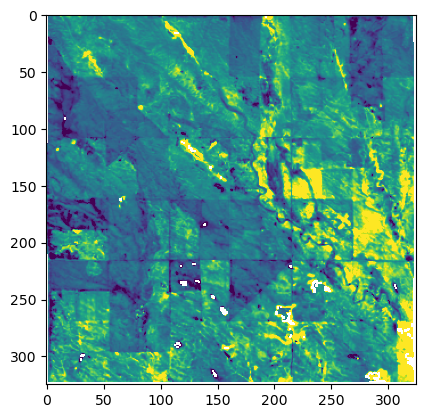

<AxesSubplot:>

In [7]:
bm_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['Biomass'].isel(date=slice(165, 244)),
                          input_core_dims=[['date']],
                          vectorize=True,
                          dask='parallelized')
bm_slope = bm_slope.rio.reproject('EPSG:32613').compute()
bm_slope = bm_slope.where((bm_slope > -20) & (bm_slope < 20))
bm_slope_z = (bm_slope - bm_slope.mean()) / bm_slope.std()
show(bm_slope_z.data, clim=(-2.0, 2.0))

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


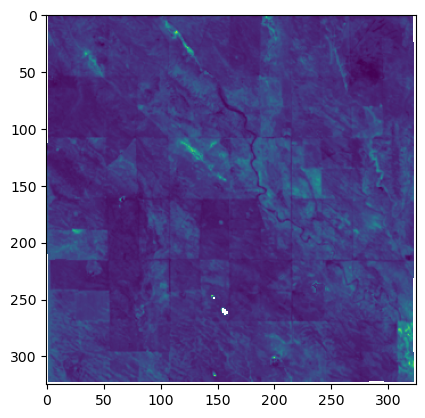

<AxesSubplot:>

In [8]:
bm_sub = hls_xr['Biomass'].isel(date=slice(235, 265)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bm_sub = bm_sub.where(bm_sub != bm_sub.rio.nodata)
show(bm_sub.data)

In [9]:
#bm_slope_z.rio.to_raster('./cnn_pred_results/tifs/bm_slope_z_julaug.tif')

In [10]:
bare_sub = hls_xr['BARE'].isel(date=slice(235, 265)).mean(dim='date').rio.reproject('EPSG:32613').compute()
bare_sub = bare_sub.where(bare_sub != bare_sub.rio.nodata)
bare_z = (bare_sub - bare_sub.mean()) / bare_sub.std()

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [12]:
bare_sub.rio.to_raster('./cnn_pred_results/tifs/bare_ground_julaug.tif')

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


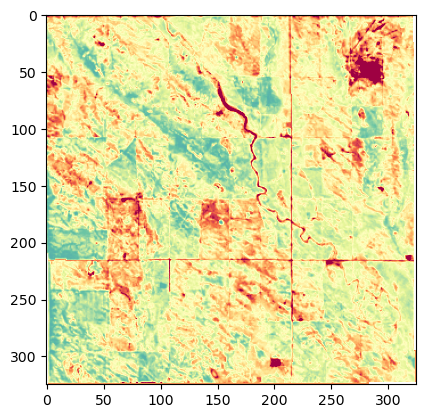

<AxesSubplot:>

In [13]:
show(bare_z.data, cmap='Spectral_r', clim=(-3.0, 3.0))

In [14]:
pts_list = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]


In [15]:
pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_density_xr = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)
pts_density_xr = pts_density_xr / focal_area_ha

/tmp/ipykernel_8366/851037890.py:1: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


In [16]:
if not os.path.exists('./cnn_pred_results/tifs/'):
    os.mkdir('./cnn_pred_results/tifs/')
#pts_density_xr.rio.to_raster('./cnn_pred_results/tifs/burrow_density' + suffix + '.tif')

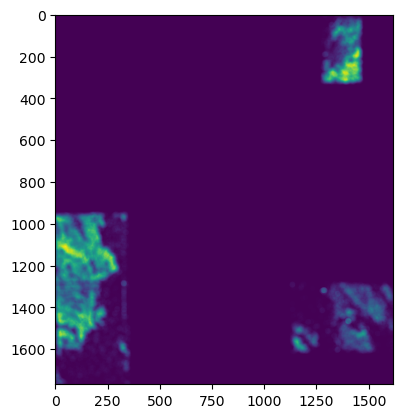

<AxesSubplot:>

In [17]:
show(pts_density_xr.data)
#pts_density_xr.isnull().all()

In [18]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

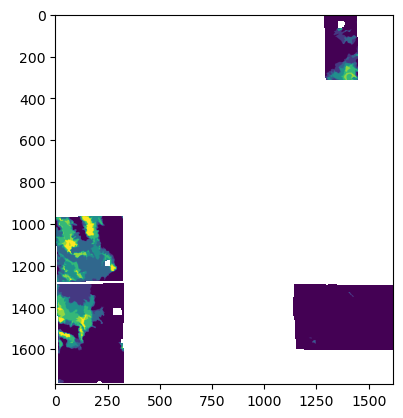

<AxesSubplot:>

In [19]:
show(da_active.data)

In [20]:
pts_density_xr = pts_density_xr.where(da_active.notnull())

In [21]:
df_active = da_active.to_dataframe(name='yrs_active').drop(columns='spatial_ref')
df_old = da_old.to_dataframe(name='yrs_old').drop(columns='spatial_ref')
df_pts_density = pts_density_xr.to_dataframe(name='pts_density').drop(columns='spatial_ref')

In [22]:
bm_slope_z = bm_slope_z.reindex_like(pts_density_xr, method='nearest')
df_bm_slope = bm_slope_z.to_dataframe(name='bm_slope_z').drop(columns='spatial_ref')

In [23]:
bare_z = bare_z.reindex_like(pts_density_xr, method='nearest')
df_bare = bare_z.to_dataframe(name='bare_z').drop(columns='spatial_ref')

In [24]:
df_out = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                df_active, df_old, left_index=True, right_index=True),
            df_pts_density, left_index=True, right_index=True),
        df_bm_slope, left_index=True, right_index=True),
    df_bare, left_index=True, right_index=True)
    

In [25]:
bm_xr = bm_sub.reindex_like(pts_density_xr, method='nearest')
df_out['bm'] = bm_xr.to_dataframe(name='bm')['bm']

In [26]:
bare_xr = bare_sub.reindex_like(pts_density_xr, method='nearest')
df_out['bare'] = bare_xr.to_dataframe(name='bare')['bare']

In [27]:
df_out

band_x  yrs_active  band_y  yrs_old  band  \
y            x                                                        
4.524365e+06 519167.8595       1         NaN       1      NaN     1   
             519172.8595       1         NaN       1      NaN     1   
             519177.8595       1         NaN       1      NaN     1   
             519182.8595       1         NaN       1      NaN     1   
             519187.8595       1         NaN       1      NaN     1   
...                          ...         ...     ...      ...   ...   
4.515525e+06 527232.8595       1         NaN       1      NaN     1   
             527237.8595       1         NaN       1      NaN     1   
             527242.8595       1         NaN       1      NaN     1   
             527247.8595       1         NaN       1      NaN     1   
             527252.8595       1         NaN       1      NaN     1   

                          pts_density  bm_slope_z    bare_z           bm  \
y            x                                                             
4.524365e+06 519167.8595          NaN   -0.222503  0.821674   536.765198   
             519172.8595          NaN    0.075738  0.762297   570.322693   
             519177.8595          NaN    0.075738  0.762297   570.322693   
             519182.8595          NaN    0.075738  0.762297   570.322693   
             519187.8595          NaN    0.075738  0.762297   570.322693   
...                               ...         ...       ...          ...   
4.515525e+06 527232.8595          NaN    5.362992 -0.355520  1380.135376   
             527237.8595          NaN    5.362992 -0.355520  1380.135376   
             527242.8595          NaN    6.592637 -0.411841  2436.921631   
             527247.8595          NaN    6.592637 -0.411841  2436.921631   
             527252.8595          NaN    6.592637 -0.411841  2436.921631   

                              bare  
y            x                      
4.524365e+06 519167.8595  0.201582  
             519172.8595  0.197280  
             519177.8595  0.197280  
             519182.8595  0.197280  
             519187.8595  0.197280  
...                            ...  
4.515525e+06 527232.8595  0.116285  
             527237.8595  0.116285  
             527242.8595  0.112204  
             527247.8595  0.112204  
             527252.8595  0.112204  

[2862242 rows x 10 columns]

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

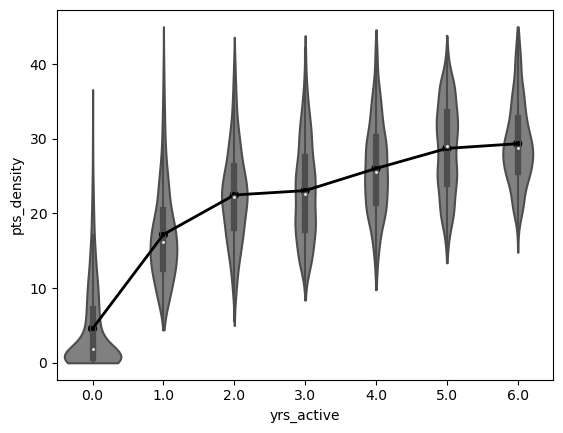

In [28]:
ax = sns.violinplot(x='yrs_active', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_active', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

<AxesSubplot:xlabel='yrs_old', ylabel='pts_density'>

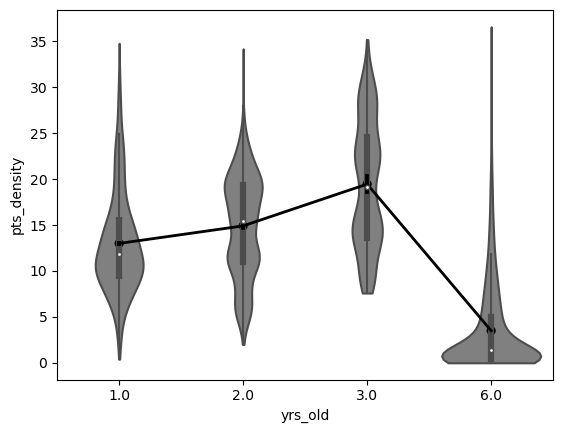

In [29]:
ax = sns.violinplot(x='yrs_old', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_old', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

In [30]:
df_val = pd.DataFrame(columns=['yrs_thresh', 'pts_thresh', 'jscore'])
idx=0
for yrs_thresh in tqdm(range(0, 6)):
    for pts_thresh in range(0, 51, 2):
        df_out['y_true'] = df_out['yrs_active'] > yrs_thresh
        df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
        jscore = jaccard_score(y_true=df_out['y_true'],
                      y_pred=df_out['y_pred'])
        df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': yrs_thresh,
                                                  'pts_density': pts_thresh,
                                                  'jscore': jscore}, index=[idx])])
        idx+=1

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:06<00:00, 11.03s/it]


In [31]:
for pts_thresh in tqdm(range(0, 51, 2)):
    df_out['y_true'] = (df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)
    df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': -1,
                                              'pts_density': pts_thresh,
                                              'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.33it/s]


In [32]:
df_out['box_x'] = df_out.apply(lambda x: -1 if x['yrs_old'] == 1 else x['yrs_active'], axis=1)
df_out_boxplot = df_out.loc[df_out['box_x'].notnull()].copy()

In [33]:
df_out_boxplot['box_x'] = df_out_boxplot['box_x'].astype('int')
df_out_boxplot['box_x'].loc[df_out_boxplot['box_x'] == 0] = 'N/A'

/tmp/ipykernel_8366/1536855321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_boxplot['box_x'].loc[df_out_boxplot['box_x'] == 0] = 'N/A'


In [34]:
df_val_smry = pd.DataFrame(df_val.groupby('yrs_thresh').apply(
    lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])).droplevel(level=1)
df_val_smry['jscore'] = df_val.groupby('yrs_thresh').apply(lambda x: x['jscore'].max())
display(round(df_val_smry, 2))

,pts_density,jscore
yrs_thresh,,
-1,10.0,0.77
0,14.0,0.74
1,16.0,0.70
2,18.0,0.48
3,24.0,0.39
4,28.0,0.21
5,28.0,0.11


In [35]:
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]

Text(-0.16, 0.975, '(b)')

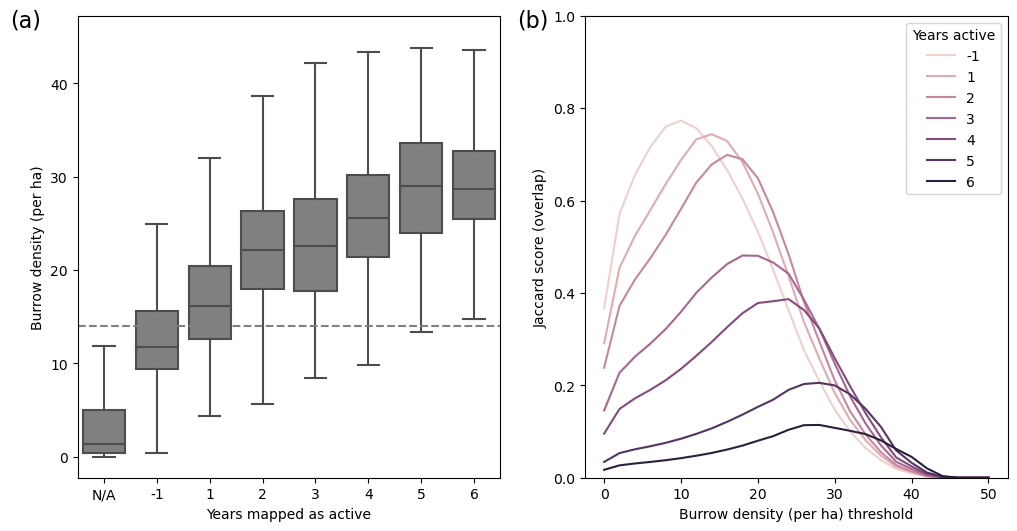

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='box_x', y='pts_density', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('Years mapped as active')
axs[0].axhline(y=pts_thresh, linestyle='dashed', color='grey')

sns.lineplot(x='pts_density', y='jscore', data=df_val, hue='yrs_thresh', ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Burrow density (per ha) threshold')
axs[1].set_ylim(0, 1.0)
axs[1].legend(title='Years active', labels=['-1', '1', '2', '3', '4', '5', '6'])

axs[0].annotate('(a)', (-0.16, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.16, 0.975), xycoords='axes fraction', fontsize=16)

#plt.savefig('./results_figs/colony_age_and_burrow_density_plot' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [37]:
df_bm_slope_val = pd.DataFrame(columns=['bm_slope_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bm_slope_z'] < zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bm_slope_val = pd.concat([df_bm_slope_val, pd.DataFrame({'bm_slope_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.33it/s]


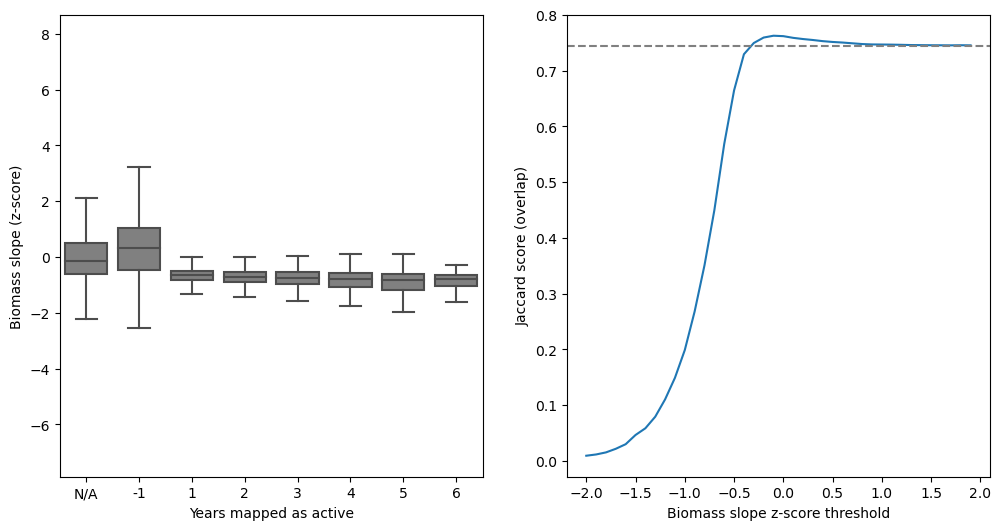

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bm_slope_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Biomass slope (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bm_slope_z', y='jscore', data=df_bm_slope_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Biomass slope z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [39]:
df_bm_slope_val[(df_bm_slope_val['jscore'].max() - df_bm_slope_val['jscore']) < 0.005]

,bm_slope_z,jscore
18,-2.000000e-01,0.759211
19,-1.000000e-01,0.762499
20,1.776357e-15,0.761731
21,1.000000e-01,0.758683


In [40]:
df_bare_val = pd.DataFrame(columns=['bare_z', 'jscore'])
idx = 0
for zscore in tqdm(np.arange(-2.0, 2.0, 0.1)):
    df_out['y_true'] = (df_out['yrs_active'] > 0)
    df_out['y_pred'] = (df_out['pts_density'] >= df_val_smry['pts_density'][df_val_smry.index==0][0]) & (df_out['bare_z'] > zscore)
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_bare_val = pd.concat([df_bare_val, pd.DataFrame({'bare_z': zscore,
                                                                'jscore': jscore}, index=[idx])])
    idx+=1
        

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.33it/s]


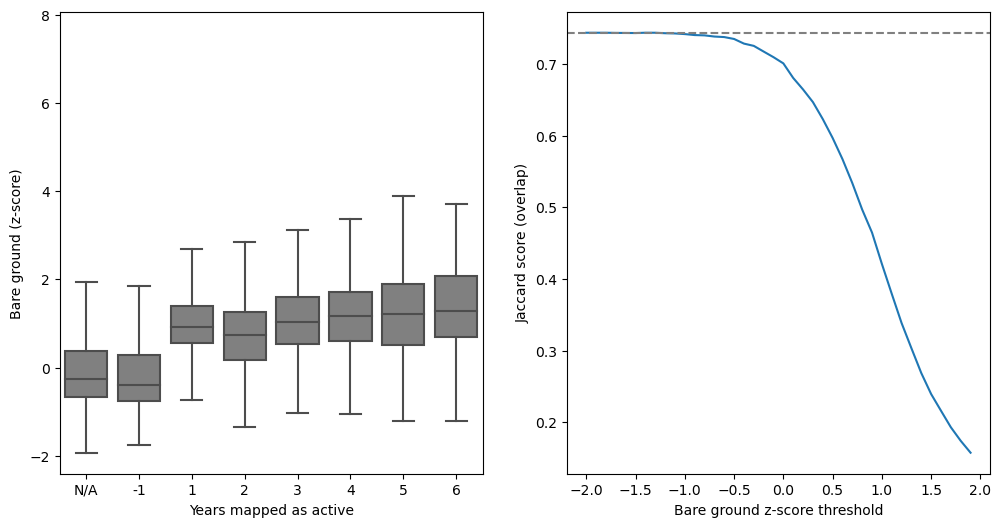

In [41]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='box_x', y='bare_z', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Bare ground (z-score)')
axs[0].set_xlabel('Years mapped as active')

sns.lineplot(x='bare_z', y='jscore', data=df_bare_val, ax=axs[1])
axs[1].set_ylabel('Jaccard score (overlap)')
axs[1].set_xlabel('Bare ground z-score threshold')
axs[1].axhline(y=df_val_smry['jscore'][df_val_smry.index==0][0], linestyle='dashed', color='grey')

In [42]:
df_bare_val[(df_bare_val['jscore'].max() - df_bare_val['jscore']) < 0.005]

,bare_z,jscore
0,-2.0,0.743554
1,-1.9,0.743554
2,-1.8,0.743554
3,-1.7,0.743332
4,-1.6,0.743244
5,-1.5,0.743130
6,-1.4,0.743581
7,-1.3,0.743552
8,-1.2,0.742888
9,-1.1,0.742572


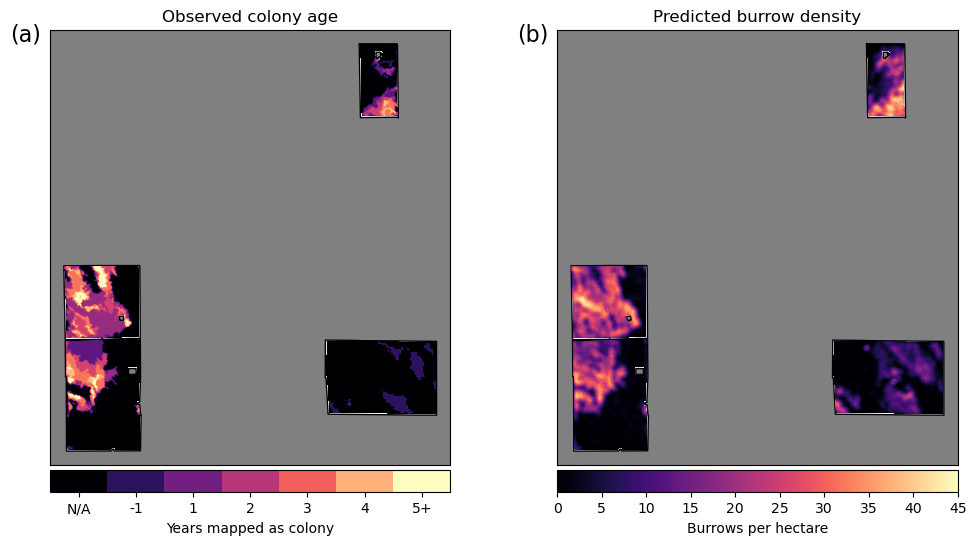

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
cmap_density = 'magma'
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_buff_m = 300
cper.plot(fc='white', ec='black', ax=axs[0])
show(da_active.data, ax=axs[0], transform=da_active.rio.transform(), zorder=5, cmap=cmap_density)
show(da_old.where(da_old == 1).data, ax=axs[0], transform=da_old.rio.transform(), clim=(0, 6), zorder=8, cmap=cmap_density)
p_active = show(da_active.where(da_active > 0).data, ax=axs[0], transform=da_active.rio.transform(),
                clim=(-1, 6), zorder=10, cmap=cmap_density)
axs[0].set_title('Observed colony age')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density = show(pts_density_xr.data, ax=axs[1], transform=pts_density_xr.rio.transform(), zorder=10, cmap=cmap_density)
axs[1].set_title('Predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
    ax.set_facecolor('grey')
axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

# colorbar for first plot
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = ColorbarBase(ax=cax1, 
                     cmap=plt.get_cmap(cmap_density, 7), 
                     norm=BoundaryNorm(np.arange(0, 8), 8),
                     ticks=np.arange(0.5, 7.5),
                     label='Years mapped as colony',
                     orientation='horizontal')
cbar1.ax.set_xticklabels(['N/A', -1, 1, 2, 3, 4, '5+'])  # horizontal colorbar

# colorbar for second plot
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density.get_images()[0],
             cax=cax2,
             orientation='horizontal', 
             label='Burrows per hectare')
#plt.savefig('./results_figs/colony_age_and_burrow_density_map' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [47]:
bm_slope_thresh = -0.2
colony_thresh = ((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).astype('float')
#colony_thresh.rio.to_raster('./cnn_pred_results/tifs/colony_threshold' + suffix + '_5ha_with_bm.tif')

In [42]:
from scipy.stats import gaussian_kde
#df_out_sub = df_out[(df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)].dropna(subset=['pts_density', 'bm_slope_z']).sample(n=5000)
df_out_sub = df_out.dropna(subset=['pts_density', 'bm_slope_z', 'bm', 'bare']).sample(n=10000)

In [43]:
xy_bm = np.vstack([df_out_sub['pts_density'], df_out_sub['bm']])
z_bm = gaussian_kde(xy_bm)(xy_bm)

xy_bare = np.vstack([df_out_sub['pts_density'], df_out_sub['bare']])
z_bare = gaussian_kde(xy_bare)(xy_bare)

xy_bm_slope = np.vstack([df_out_sub['pts_density'], df_out_sub['bm_slope_z']])
z_bm_slope = gaussian_kde(xy_bm_slope)(xy_bm_slope)

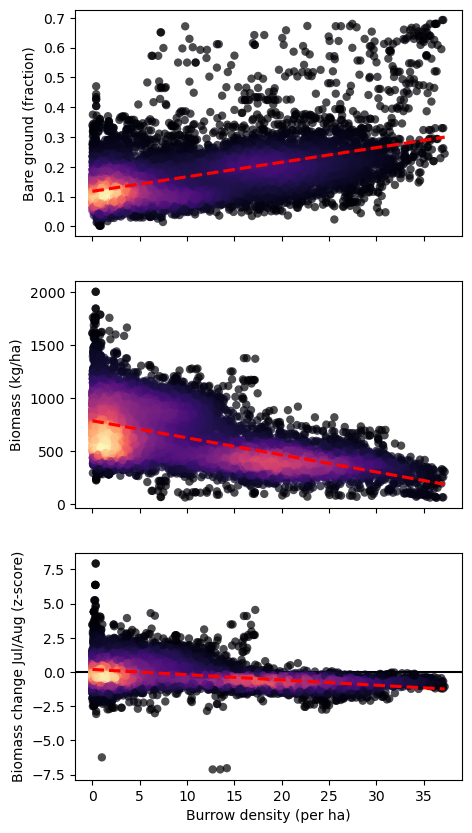

In [44]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(5, 10))
sns.scatterplot(x='pts_density', y='bare', data=df_out_sub, 
                c=z_bare, cmap='magma', ec='none', alpha=0.7, ax=axs[0])
sns.regplot(x='pts_density', y='bare', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[0])
sns.scatterplot(x='pts_density', y='bm', data=df_out_sub, 
                c=z_bm, cmap='magma', ec='none', alpha=0.7, ax=axs[1])
sns.regplot(x='pts_density', y='bm', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed'), ax=axs[1])
sns.scatterplot(x='pts_density', y='bm_slope_z', data=df_out_sub, 
                c=z_bm_slope, cmap='magma', ec='none', alpha=0.7, ax=axs[2], zorder=10)
sns.regplot(x='pts_density', y='bm_slope_z', data=df_out_sub, scatter=False, 
            line_kws=dict(color='red', linestyle='dashed', zorder=11), ax=axs[2])
axs[2].axhline(y=0, linestyle='solid', color='black', zorder=1)
axs[0].set_ylabel('Bare ground (fraction)')
axs[1].set_ylabel('Biomass (kg/ha)')
axs[2].set_ylabel('Biomass change Jul/Aug (z-score)')
axs[2].set_xlabel('Burrow density (per ha)')
#plt.savefig('./results_figs/burrow_density_and_satellite_metrics' + suffix + '_20ha.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [86]:
past_bounds = cper[cper['Past_Name_'] == '29-30'].geometry.bounds

In [87]:
df_out_boxplot_sub = df_out_boxplot.reset_index()

In [88]:
df_out_boxplot_sub = df_out_boxplot_sub[(df_out_boxplot_sub['x'] > past_bounds['minx'].values[0]) & 
                                        (df_out_boxplot_sub['x'] < past_bounds['maxx'].values[0]) & 
                                        (df_out_boxplot_sub['y'] > past_bounds['miny'].values[0]) &
                                        (df_out_boxplot_sub['y'] < past_bounds['maxy'].values[0])]

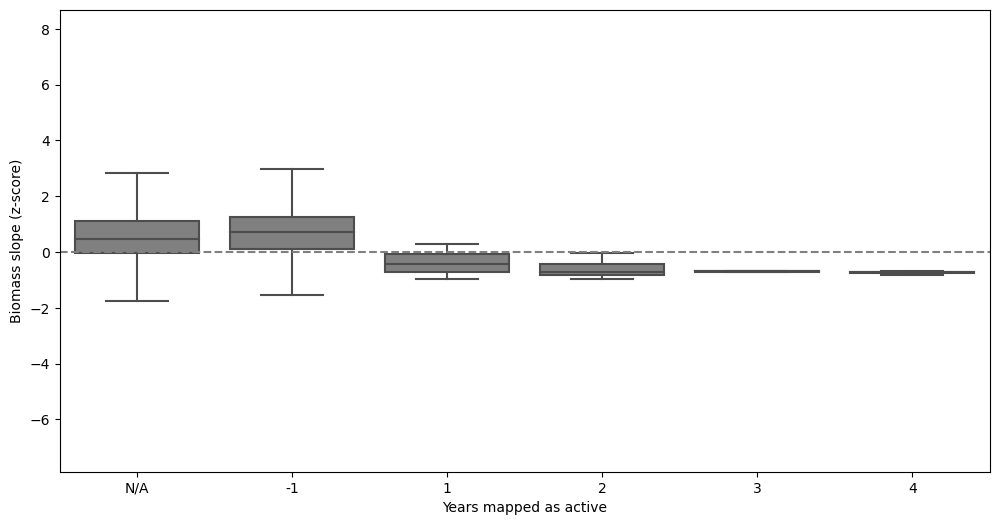

In [94]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
sns.boxplot(x='box_x', y='bm_slope_z', 
            data=df_out_boxplot_sub,
            order=['N/A', -1, 1, 2, 3, 4],
            fliersize=0, color='grey', ax=ax)
ax.set_ylabel('Biomass slope (z-score)')
ax.set_xlabel('Years mapped as active')
ax.axhline(y=0, linestyle='dashed', color='grey')
plt.savefig('./results_figs/bm_slope_vs_years_active_2930.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [44]:
colony_thresh = (pts_density_xr >= pts_thresh).astype('float')
colony_thresh.rio.to_raster('./cnn_pred_results/tifs/colony_threshold' + suffix + '.tif')

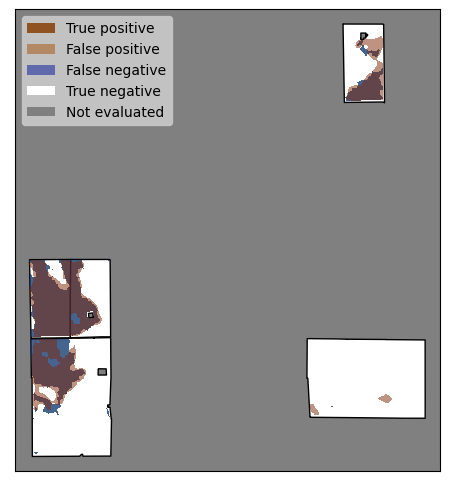

In [40]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where(pts_density_xr >= pts_thresh).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [41]:
pts_thresh

10.0

In [42]:
print('Colony area predicted from burrow density: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('False positive area: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (da_active <= 0)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('False negative area: ')
print('  ', np.round((((pts_density_xr < pts_thresh) & (da_active > 0)).sum()*5.0**2*0.0001).values, 1), 'ha')


print('---------------')
print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   362.8 ha
Colony area mapped in 2021: 
   337.8 ha
False positive area: 
   56.9 ha
False negative area: 
   31.9 ha
---------------
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   353.1 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


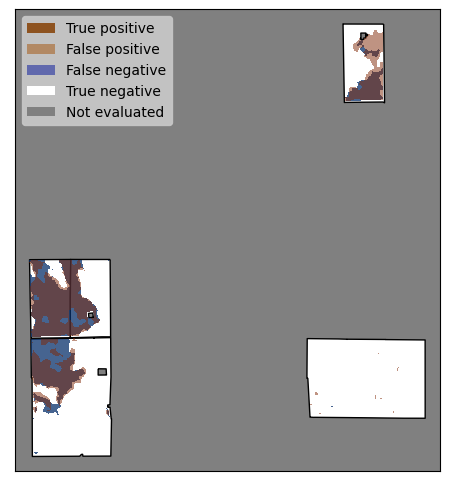

In [40]:
bm_slope_thresh = -0.1

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + 'with_bm_thresh.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [41]:
print('Colony area predicted from burrow density: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   347.1 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   337.9 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


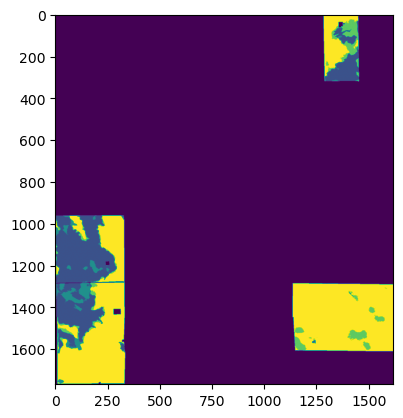

<AxesSubplot:>

In [42]:
da_result = xr.zeros_like(da_active)
da_result = da_result + ((da_active > 0) & (pts_density_xr >= pts_thresh))
da_result = da_result + ((da_active > 0) & (pts_density_xr < pts_thresh)) * 2
da_result = da_result + ((da_active == 0) & (pts_density_xr >= pts_thresh)) * 3
da_result = da_result + ((da_active == 0) & (pts_density_xr < pts_thresh)) * 4
show(da_result.data, clim=(0, 4))

In [43]:
pred_result_dict = {
    0: np.nan,
    1: 'True positive',
    2: 'False negative',
    3: 'False positive',
    4: 'True negative'
}
df_out['pred_result'] = da_result.to_dataframe(name='pred_result')['pred_result'].apply(lambda x: pred_result_dict[x])

In [44]:
from skimage.measure import label, regionprops
pr_burrow_labels = label((pts_density_xr >= pts_thresh))
pr_burrow_regions = regionprops(pr_burrow_labels)

pr_non_labels = label((pts_density_xr < pts_thresh))
pr_non_regions = regionprops(pr_non_labels)

In [45]:
area_thresh = 30
sm_burrow_labels = [x.label for x in pr_burrow_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
sm_non_labels = [x.label for x in pr_non_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
xr_burrow_labels = (xr.ones_like(pts_density_xr) * pr_burrow_labels).astype('int')
xr_non_labels = (xr.ones_like(pts_density_xr) * pr_non_labels).astype('int')

In [46]:
df_out['sm_burrow_area'] = xr_burrow_labels.where(
    xr_burrow_labels.isin(sm_burrow_labels)).to_dataframe(
    name='sm_burrow_labels')['sm_burrow_labels'].notnull()
df_out['sm_non_area'] = xr_non_labels.where(
    xr_non_labels.isin(sm_non_labels)).to_dataframe(
    name='sm_non_labels')['sm_non_labels'].notnull()
df_out['sm_area'] = df_out['sm_burrow_area'] | df_out['sm_non_area']

<AxesSubplot:>

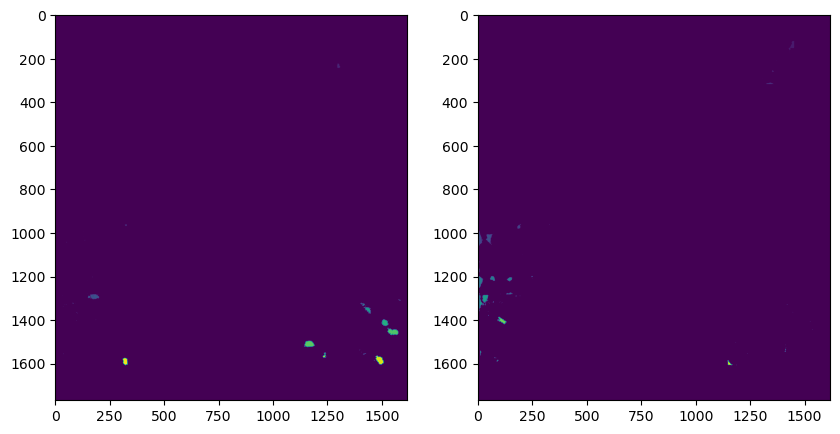

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 6))
show(xr_burrow_labels.where(xr_burrow_labels.isin(sm_burrow_labels), other=-1).data, ax=axs[0])
show(xr_non_labels.where(xr_non_labels.isin(sm_non_labels), other=-1).data, ax=axs[1])

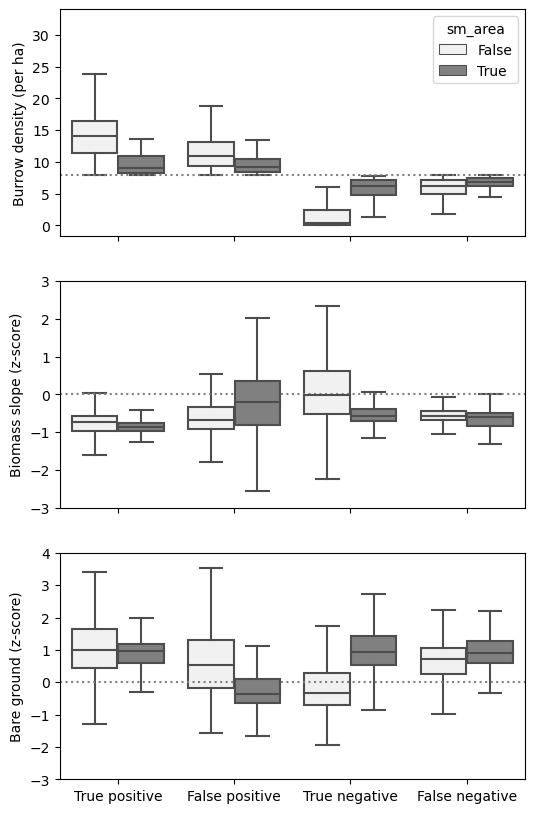

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 10),
            sharex=True)
sns.boxplot(x='pred_result', y='pts_density', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('')
axs[0].axhline(y=pts_thresh, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bm_slope_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[1])
axs[1].set_ylabel('Biomass slope (z-score)')
axs[1].set_xlabel('')
axs[1].set_ylim(-3.0, 3.0)
axs[1].legend().remove()
axs[1].axhline(y=0, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bare_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[2])
axs[2].set_ylabel('Bare ground (z-score)')
axs[2].set_xlabel('')
axs[2].set_ylim(-3.0, 4.0)
axs[2].legend().remove()
axs[2].axhline(y=0, linestyle='dotted', color='grey')